Van 1 optimized route (distance: 4.05 miles): [79, 85, 17, 60, 97, 78, 2, 57, 58, 5, 32, 45, 15, 22]
Van 2 optimized route (distance: 4.86 miles): [7, 33, 9, 18, 3, 27, 52, 86, 31, 47, 36]
Van 3 optimized route (distance: 5.38 miles): [20, 26, 19, 43, 90, 81, 96, 71, 35, 98, 11, 16, 34, 39, 67, 13, 84, 80, 23, 54, 12]
Van 4 optimized route (distance: 4.82 miles): [25, 75, 21, 28, 6, 95, 46, 92, 24]
Van 5 optimized route (distance: 5.25 miles): [56, 68, 61, 89, 73, 83, 4, 53, 1]
Van 6 optimized route (distance: 3.78 miles): [82, 87, 44, 37, 76, 38, 63]
Van 7 optimized route (distance: 5.71 miles): [72, 64, 74, 40, 69, 70, 41, 8, 50, 49, 51, 55, 59, 62]
Van 8 optimized route (distance: 4.53 miles): [48, 88, 29, 99, 66, 14, 93]
Van 9 optimized route (distance: 3.19 miles): [10, 42]
Van 10 optimized route (distance: 4.03 miles): [94, 91, 77, 0, 65, 30]


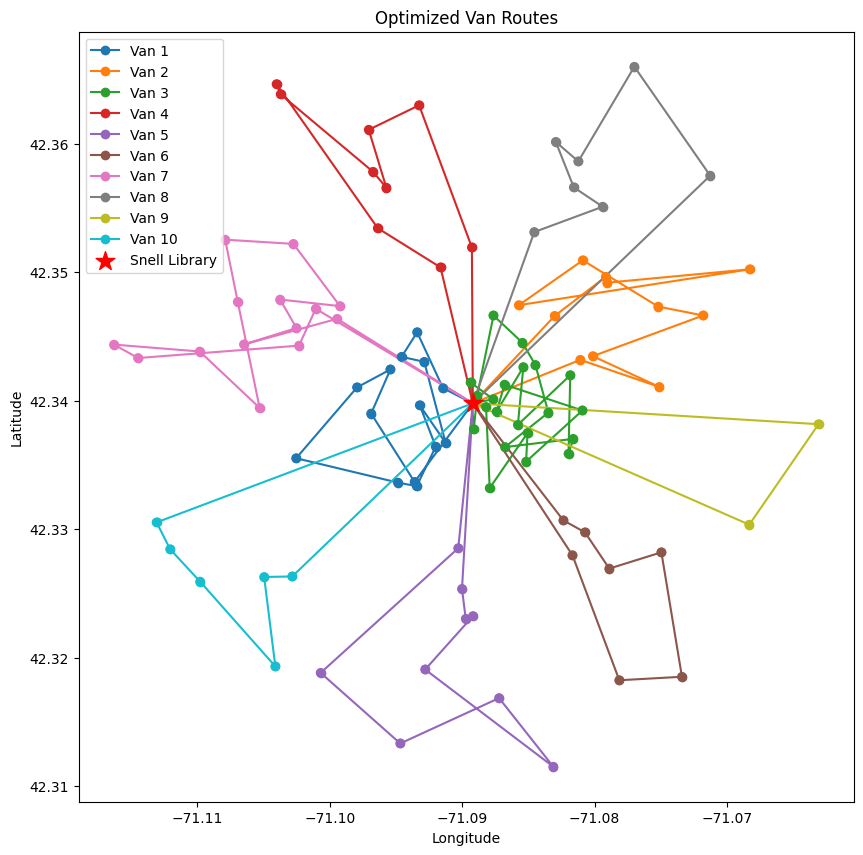

In [3]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

NUM_VANS = 10
VAN_CAPACITY = 12
NUM_STUDENTS = 100

SNELL_LIBRARY = (42.3398, -71.0892)

def generate_random_locations(num_points, center, radius_miles=2):
    locations = []
    for _ in range(num_points):
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius_miles)

        delta_lat = distance * math.cos(angle) * 0.0145
        delta_lon = distance * math.sin(angle) * 0.0145

        lat = center[0] + delta_lat
        lon = center[1] + delta_lon
        locations.append((lat, lon))

    return np.array(locations)

def haversine(coord1, coord2):
    R = 3959
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def calculate_total_distance(route, locations):
    total_distance = 0
    prev_location = SNELL_LIBRARY

    for idx in route:
        total_distance += haversine(prev_location, locations[idx])
        prev_location = locations[idx]

    total_distance += haversine(prev_location, SNELL_LIBRARY)
    return total_distance

def generate_neighbor(route):
    new_route = route[:]
    i, j = random.sample(range(len(route)), 2)
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def simulated_annealing(locations, initial_temp=1000, cooling_rate=0.995, max_iter=500):
    num_stops = len(locations)
    current_route = list(range(num_stops))
    current_cost = calculate_total_distance(current_route, locations)

    best_route = current_route[:]
    best_cost = current_cost

    temp = initial_temp

    for _ in range(max_iter):
        neighbor = generate_neighbor(current_route)
        neighbor_cost = calculate_total_distance(neighbor, locations)

        if neighbor_cost < current_cost or random.random() < math.exp((current_cost - neighbor_cost) / temp):
            current_route = neighbor
            current_cost = neighbor_cost

        if current_cost < best_cost:
            best_route = current_route[:]
            best_cost = current_cost

        temp *= cooling_rate

    return best_route, best_cost

def plot_routes(van_routes, all_locations, cluster_labels):
    plt.figure(figsize=(10, 10))

    for van_id, route in van_routes.items():
        route_locations = [SNELL_LIBRARY] + [all_locations[i] for i in route] + [SNELL_LIBRARY]
        route_locations = np.array(route_locations)

        plt.plot(route_locations[:, 1], route_locations[:, 0], marker='o', label=f'Van {van_id+1}')

    plt.scatter(all_locations[:, 1], all_locations[:, 0], c=cluster_labels, cmap='tab10', zorder=2)
    plt.scatter(SNELL_LIBRARY[1], SNELL_LIBRARY[0], c='red', marker='*', s=200, label='Snell Library', zorder=3)

    plt.legend()
    plt.title("Optimized Van Routes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


def main():

    student_locations = generate_random_locations(NUM_STUDENTS, SNELL_LIBRARY)

    kmeans = KMeans(n_clusters=NUM_VANS, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(student_locations)

    van_routes = {}

    for van_id in range(NUM_VANS):
        van_indices = [i for i, label in enumerate(cluster_labels) if label == van_id]

        if len(van_indices) > 0:

            van_locations = student_locations[van_indices]

            optimized_route, total_distance = simulated_annealing(van_locations)

            van_routes[van_id] = [van_indices[i] for i in optimized_route]

            print(f"Van {van_id+1} optimized route (distance: {total_distance:.2f} miles): {van_routes[van_id]}")

    plot_routes(van_routes, student_locations, cluster_labels)

if __name__ == "__main__":
    main()
